In [1]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
import pandas as pd
from global_model_periodic import LearnedSimulator_periodic
from tqdm import tqdm
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision('high')

In [3]:
normalization_stats = {
    "velocity": {"mean": torch.tensor([0.0, 0.0]).to(device), "std": torch.tensor([1e-3, 1e-3]).to(device)},
    "acceleration": {"mean": torch.tensor([0.0, 0.0]).to(device), "std": torch.tensor([1e-3, 1e-3]).to(device)}
}

In [18]:
checkpoint = torch.load("/home/jeanlienhard/Documents/Cell_GNN/GNN for acceleration/Supervised/Training/acceleration_15Conv_256/model_15.pth")
new_state_dict = {k.replace("_orig_mod.", ""): v for k, v in checkpoint.items()}
model = LearnedSimulator_periodic(num_dimensions=2, normalization_stats=normalization_stats, device=device)
model.load_state_dict(new_state_dict)
model.to(device)

LearnedSimulator_periodic(
  (graph_network): EncodeProcessDecode(
    (_encoder_network): GraphIndependent(
      (edge_model): Sequential(
        (0): Sequential(
          (0): Linear(in_features=1, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=1, bias=True)
        )
        (1): LayerNorm((1,), eps=1e-05, elementwise_affine=True)
      )
      (node_model): Sequential(
        (0): Sequential(
          (0): Linear(in_features=22, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
        )
        (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
    )
    (_processor_networks): ModuleList(
      (0): GNNModel(
        (gcn_layers): ModuleList(
          (0-14): 15 x NodeGNN()
        )
      )
    )
    (_decoder_network): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_fe

In [19]:
def generate_next_positions(model, device, vrai_pos,n_cells):
    model.eval()
    pos = vrai_pos.copy()
    x = torch.tensor(np.stack(pos, axis=1), dtype=torch.float32).to(device)
    next_position, acc = model(x,n_cells)
    for i in range(len(pos)-1):
        pos[i] = pos[i+1].copy()
    pos[-1] = next_position.cpu().detach().numpy()
    return pos,acc

In [20]:
def create_csv_with_predictions(model,n_cells, device, input_csv, steps=200):
    model.eval()
    loss = []
    df = pd.read_csv(input_csv)
    steps_list = df["step"].unique()
    pos = []
    loss_fn = nn.MSELoss()
    vrai_pos = []
    norm_acc = []
    for step in steps_list[:5]:
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        pos.append(positions.copy())
        vrai_pos.append(positions.copy())
    for step in steps_list[5:steps]:
        pos,acc = generate_next_positions(model, device, vrai_pos,n_cells)
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        for i in range(len(vrai_pos)-1):
             vrai_pos[i] = vrai_pos[i+1].copy()
        vrai_pos[-1] = positions.copy()
        print(acc,(vrai_pos[-1]-vrai_pos[-2])[:n_cells]*1e3,pos[-1],vrai_pos[-1])
        if step%1==0:
            norm_acc.append(np.linalg.norm((vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[0]))
            loss.append(loss_fn(acc/1e3,torch.tensor((vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells], dtype=torch.float32).to(device)).cpu().detach().numpy())
    return loss,norm_acc

In [21]:
loss,acc = create_csv_with_predictions(model,10, device, "/home/jeanlienhard/Documents/Cell_GNN/Data/raw_data/positions_2.csv",200)

tensor([[ 0.1312,  0.0003],
        [-0.0651, -0.0373],
        [-0.0213,  0.0572],
        [-0.1283,  0.1234],
        [ 0.0556,  0.1499],
        [ 0.0974, -0.0246],
        [ 0.0253, -0.1190],
        [-0.0911, -0.1372],
        [ 0.0987, -0.0075],
        [-0.0856,  0.0078]], device='cuda:0', grad_fn=<AddmmBackward0>) [[ 0.822702    0.0052639 ]
 [-0.41091021 -0.2586044 ]
 [-0.1472685   0.3361555 ]
 [-0.8693182   0.7509962 ]
 [ 0.2950303   0.8905587 ]
 [ 0.5687514  -0.1768676 ]
 [ 0.1934091  -0.7204028 ]
 [-0.5512413  -0.8074625 ]
 [ 0.6329858  -0.0414471 ]
 [-0.5341403   0.0218101 ]] [[ 0.13449341  0.22188847]
 [ 0.01009933 -0.64161146]
 [ 0.63285726 -0.63187975]
 [ 0.16626969 -0.15305848]
 [-0.94828016 -0.3643486 ]
 [-0.8754498  -0.8332992 ]
 [ 0.95425826  0.95359063]
 [ 0.7458414  -0.8966849 ]
 [-0.4598084  -0.8154745 ]
 [ 0.7600559   0.12523009]
 [ 0.13449341  2.221888  ]
 [ 0.01009933  1.3583884 ]
 [ 0.63285726  1.3681201 ]
 [ 0.16626969  1.8469417 ]
 [-0.94828016  1.6356514 ]


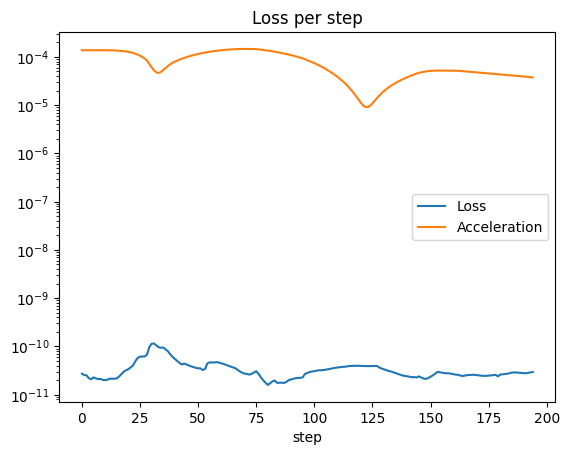

In [22]:
plt.plot(loss, label='Loss')
plt.plot(acc, label='Acceleration')
plt.yscale('log')
plt.xlabel('step')
plt.legend()
plt.title('Loss per step')
plt.show()

In [26]:
def create_csv_with_real_predictions(model,n_cells, device, input_csv, output_csv, steps=200):
    model.eval()
    loss = []
    df = pd.read_csv(input_csv)
    steps_list = df["step"].unique()
    results = []
    pos = []
    vrai_pos = []
    loss_fn = nn.MSELoss()
    for step in steps_list[:5]:
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        pos.append(positions.copy())
        vrai_pos.append(positions.copy())
    for step in steps_list[5:steps]:
        pos,acc = generate_next_positions(model, device, pos,n_cells)
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        for i in range(len(vrai_pos)-1):
             vrai_pos[i] = vrai_pos[i+1].copy()
        vrai_pos[-1] = positions.copy()
        print(acc,(vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells]*1e3)
        if step%1==0:
            loss.append(loss_fn(acc/1e3,torch.tensor((vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells], dtype=torch.float32).to(device)).cpu().detach().numpy())
        for id_, positions in enumerate(pos[-1]):
                results.append({"step": step, "site_index": id_, "x": positions[0], "y": positions[1]})
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv}")
    return loss

In [29]:
loss = create_csv_with_real_predictions(model,10, device, "/home/jeanlienhard/Documents/Cell_GNN/Data/raw_data/positions_11.csv", "/home/jeanlienhard/Documents/Cell_GNN/GNN for acceleration/Supervised/Training/acceleration_15Conv_256/computed_trajectories/computed_positions_11.csv",205)

tensor([[-0.0365, -0.1015],
        [-0.0453,  0.0616],
        [ 0.0170,  0.1562],
        [-0.1977, -0.0661],
        [ 0.0983, -0.1407],
        [ 0.0063, -0.0778],
        [ 0.1751,  0.0649],
        [ 0.1031, -0.0429],
        [ 0.0023,  0.0041],
        [-0.0933,  0.1409]], device='cuda:0', grad_fn=<AddmmBackward0>) [[-0.0337799  -0.099999  ]
 [-0.0473448   0.0594191 ]
 [ 0.0095646   0.1601872 ]
 [-0.2184347  -0.0709239 ]
 [ 0.1073957  -0.1427259 ]
 [ 0.0074248  -0.0823934 ]
 [ 0.183268    0.0717017 ]
 [ 0.09706166 -0.04222019]
 [-0.0011813   0.0040746 ]
 [-0.103974    0.1428798 ]]
tensor([[-0.0370, -0.1035],
        [-0.0454,  0.0629],
        [ 0.0165,  0.1562],
        [-0.1922, -0.0657],
        [ 0.0930, -0.1395],
        [ 0.0063, -0.0781],
        [ 0.1734,  0.0644],
        [ 0.1030, -0.0446],
        [ 0.0022,  0.0044],
        [-0.0891,  0.1405]], device='cuda:0', grad_fn=<AddmmBackward0>) [[-0.0337062  -0.0994601 ]
 [-0.0473731   0.0589142 ]
 [ 0.0083972   0.1601505 ]


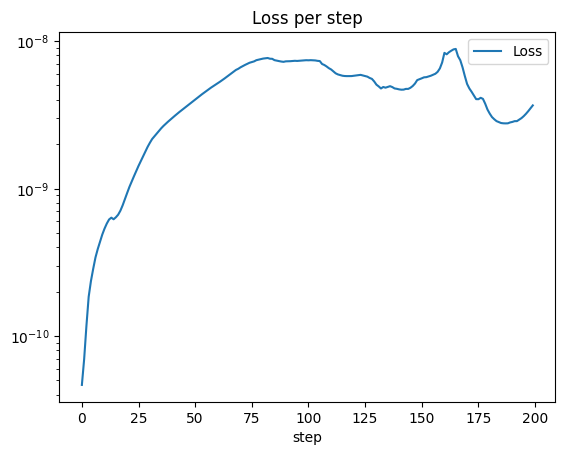

In [30]:
plt.plot(loss, label='Loss')
plt.yscale('log')
plt.xlabel('step')
plt.legend()
plt.title('Loss per step')
plt.show()